# k-Nearest Neighbor

## Imports

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [46]:
TRAIN_CSV = '../data/activity_train.csv'   # path to train CSV
TEST_CSV  = '../data/activity_test.csv'    # path to test CSV

label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}

## Dataset

In [47]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)
print('train shape:', df_train.shape)
print('test  shape:', df_test.shape)

X_train = df_train.drop(columns=['activity'])
y_train = df_train['activity'].copy()
X_test = df_test.drop(columns=['activity'])
y_test = df_test['activity'].copy()

train_cols = list(X_train.columns)
test_cols = list(X_test.columns)
X_test = X_test[train_cols]

labels = np.unique(y_test)
label_names = [label_map.get(int(l), str(l)) for l in labels]

train shape: (7767, 562)
test  shape: (3162, 562)


# KNN


--- subset: time ---
k=1  CV f1_macro=0.8454  Test accuracy=0.8365
k=3  CV f1_macro=0.8475  Test accuracy=0.8526
k=5  CV f1_macro=0.8513  Test accuracy=0.8615
k=7  CV f1_macro=0.8441  Test accuracy=0.8662
k=9  CV f1_macro=0.8315  Test accuracy=0.8719
k=11  CV f1_macro=0.8345  Test accuracy=0.8675
k=15  CV f1_macro=0.8268  Test accuracy=0.8707
k=21  CV f1_macro=0.8042  Test accuracy=0.8659

--- subset: freq ---
k=1  CV f1_macro=0.6504  Test accuracy=0.6818
k=3  CV f1_macro=0.6471  Test accuracy=0.7116
k=5  CV f1_macro=0.6535  Test accuracy=0.7324
k=7  CV f1_macro=0.6408  Test accuracy=0.7315
k=9  CV f1_macro=0.6442  Test accuracy=0.7356
k=11  CV f1_macro=0.6467  Test accuracy=0.7429
k=15  CV f1_macro=0.6345  Test accuracy=0.7445
k=21  CV f1_macro=0.6171  Test accuracy=0.7423

--- subset: combined ---
k=1  CV f1_macro=0.8429  Test accuracy=0.8346
k=3  CV f1_macro=0.8348  Test accuracy=0.8646
k=5  CV f1_macro=0.8521  Test accuracy=0.8672
k=7  CV f1_macro=0.8422  Test accuracy=0.8681
k=9 

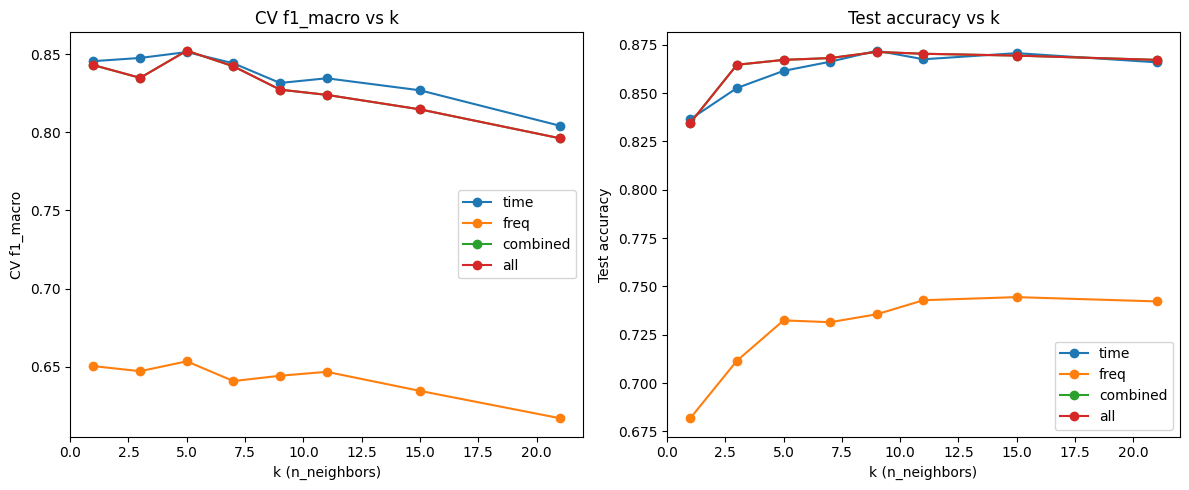


cv_f1_results = {'time': array([0.84544957, 0.84750378, 0.85126336, 0.84409431, 0.83149275,
       0.83449917, 0.82680781, 0.80415067]), 'freq': array([0.65037556, 0.64713641, 0.6534536 , 0.64082467, 0.64421738,
       0.64673446, 0.63453686, 0.61706409]), 'combined': array([0.84291714, 0.83477815, 0.85213234, 0.84215185, 0.82723004,
       0.8238954 , 0.8146165 , 0.79613196]), 'all': array([0.84291714, 0.83477815, 0.85213234, 0.84215185, 0.82723004,
       0.8238954 , 0.8146165 , 0.79613196])}

test_acc_results = {'time': array([0.83649589, 0.85262492, 0.86148008, 0.86622391, 0.87191651,
       0.86748893, 0.87065149, 0.86590765]), 'freq': array([0.68184693, 0.71157495, 0.73244782, 0.73149905, 0.73561037,
       0.74288425, 0.74446553, 0.74225174]), 'combined': array([0.83459836, 0.86464263, 0.86717268, 0.86812144, 0.871284  ,
       0.87033523, 0.86938646, 0.86717268]), 'all': array([0.83459836, 0.86464263, 0.86717268, 0.86812144, 0.871284  ,
       0.87033523, 0.86938646, 0.8671726

In [48]:
# k sweep (CV f1_macro) + test accuracy per subset — store results and plot (no Wilcoxon)

# split columns (adjust naming if needed)
def split_time_freq_columns(cols):
    time_cols = [c for c in cols if c.lower().startswith('t')]
    freq_cols = [c for c in cols if c.lower().startswith('f') or 'freq' in c.lower() or 'fft' in c.lower()]
    freq_cols = [c for c in freq_cols if c not in time_cols]
    return time_cols, freq_cols

time_cols, freq_cols = split_time_freq_columns(X_train.columns.tolist())
combined_cols = list(dict.fromkeys(time_cols + freq_cols))

def ensure_and_order(X_src, cols):
    X = X_src.copy()
    for c in cols:
        if c not in X.columns:
            X[c] = 0.0
    return X[cols]

subsets = {
    'time': (ensure_and_order(X_train, time_cols), ensure_and_order(X_test, time_cols)),
    'freq': (ensure_and_order(X_train, freq_cols), ensure_and_order(X_test, freq_cols)),
    'combined': (ensure_and_order(X_train, combined_cols), ensure_and_order(X_test, combined_cols)),
    'all': (X_train, X_test)
}

ks = [1,3,5,7,9,11,15,21]
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

cv_f1_results = {name: [] for name in subsets}
test_acc_results = {name: [] for name in subsets}

for name, (Xtr, Xte) in subsets.items():
    print(f'\n--- subset: {name} ---')
    for k in ks:
        pipe.set_params(knn__n_neighbors=k, knn__weights='distance')
        scores = cross_val_score(pipe, Xtr, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
        cv_mean = scores.mean()
        cv_f1_results[name].append(cv_mean)
        # fit on full training subset and evaluate accuracy on test subset
        pipe.fit(Xtr, y_train)
        y_pred = pipe.predict(Xte)
        acc = accuracy_score(y_test, y_pred)
        test_acc_results[name].append(acc)
        print(f'k={k}  CV f1_macro={cv_mean:.4f}  Test accuracy={acc:.4f}')

# convert to arrays and plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name, vals in cv_f1_results.items():
    plt.plot(ks, vals, marker='o', label=name)
plt.xlabel('k (n_neighbors)'); plt.ylabel('CV f1_macro'); plt.title('CV f1_macro vs k'); plt.legend()

plt.subplot(1,2,2)
for name, vals in test_acc_results.items():
    plt.plot(ks, vals, marker='o', label=name)
plt.xlabel('k (n_neighbors)'); plt.ylabel('Test accuracy'); plt.title('Test accuracy vs k'); plt.legend()
plt.tight_layout(); plt.show()

# print results arrays for further analysis
print('\ncv_f1_results =', {k: np.array(v) for k,v in cv_f1_results.items()})
print('\ntest_acc_results =', {k: np.array(v) for k,v in test_acc_results.items()})


Confusion matrices for best CV k per subset:

=== time (best k=5) ===
Train F1 macro: 1.0
Test  F1 macro: 0.7976
              precision    recall  f1-score   support

           1     0.8304    0.9577    0.8895       496
           2     0.8166    0.8981    0.8554       471
           3     0.9342    0.7095    0.8065       420
           4     0.8460    0.7894    0.8167       508
           5     0.8117    0.8759    0.8426       556
           6     0.9981    0.9706    0.9842       545
           7     0.8947    0.7391    0.8095        23
           8     0.9091    1.0000    0.9524        10
           9     0.6667    0.9375    0.7792        32
          10     0.6176    0.8400    0.7119        25
          11     0.8462    0.4490    0.5867        49
          12     0.7857    0.4074    0.5366        27

    accuracy                         0.8615      3162
   macro avg     0.8297    0.7979    0.7976      3162
weighted avg     0.8675    0.8615    0.8592      3162



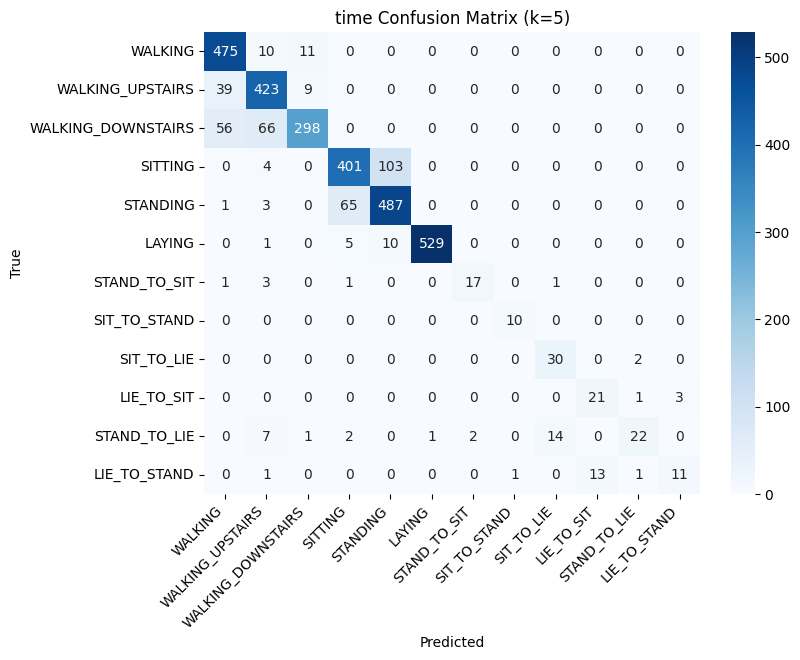


=== freq (best k=5) ===
Train F1 macro: 1.0
Test  F1 macro: 0.6216
              precision    recall  f1-score   support

           1     0.7993    0.9395    0.8638       496
           2     0.8111    0.8662    0.8378       471
           3     0.9301    0.7286    0.8171       420
           4     0.5626    0.5394    0.5508       508
           5     0.6343    0.7986    0.7070       556
           6     0.8266    0.6385    0.7205       545
           7     0.5714    0.5217    0.5455        23
           8     0.6923    0.9000    0.7826        10
           9     0.3889    0.4375    0.4118        32
          10     0.4444    0.3200    0.3721        25
          11     0.5484    0.3469    0.4250        49
          12     0.5000    0.3704    0.4255        27

    accuracy                         0.7324      3162
   macro avg     0.6425    0.6173    0.6216      3162
weighted avg     0.7407    0.7324    0.7296      3162



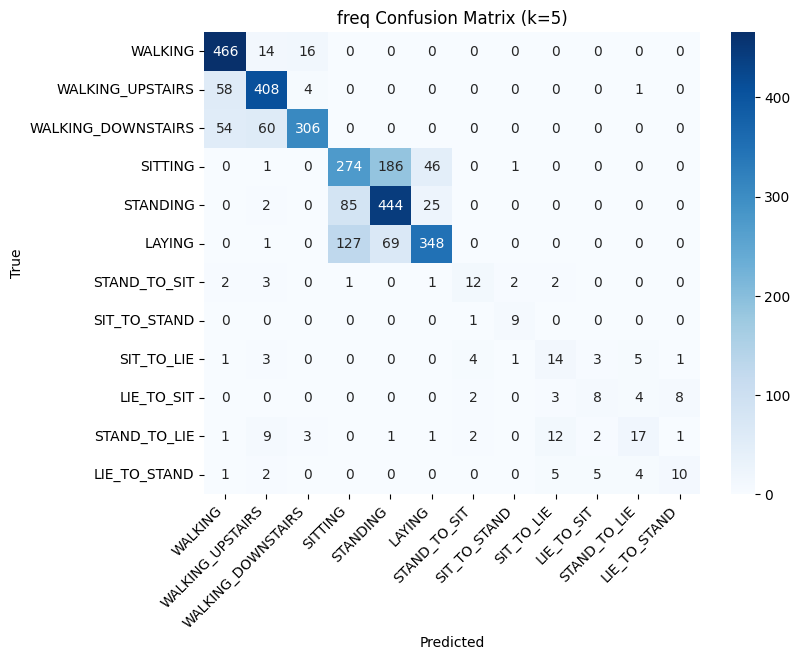


=== combined (best k=5) ===
Train F1 macro: 1.0
Test  F1 macro: 0.8046
              precision    recall  f1-score   support

           1     0.8242    0.9738    0.8928       496
           2     0.8522    0.8938    0.8725       471
           3     0.9534    0.7310    0.8275       420
           4     0.8753    0.7598    0.8135       508
           5     0.7979    0.9371    0.8619       556
           6     0.9961    0.9431    0.9689       545
           7     0.8571    0.7826    0.8182        23
           8     1.0000    1.0000    1.0000        10
           9     0.6341    0.8125    0.7123        32
          10     0.6471    0.8800    0.7458        25
          11     0.7333    0.4490    0.5570        49
          12     0.8571    0.4444    0.5854        27

    accuracy                         0.8672      3162
   macro avg     0.8357    0.8006    0.8046      3162
weighted avg     0.8751    0.8672    0.8650      3162



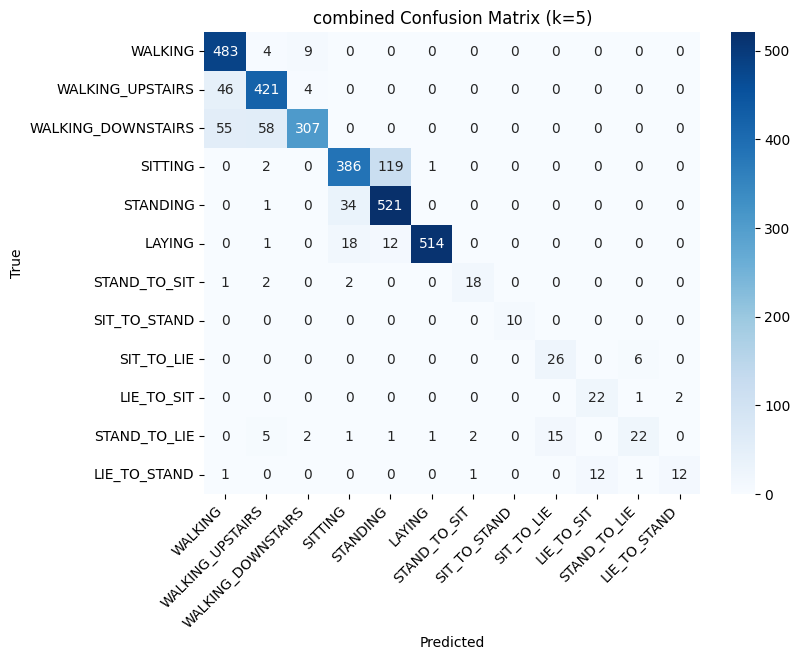


=== all (best k=5) ===
Train F1 macro: 1.0
Test  F1 macro: 0.8046
              precision    recall  f1-score   support

           1     0.8242    0.9738    0.8928       496
           2     0.8522    0.8938    0.8725       471
           3     0.9534    0.7310    0.8275       420
           4     0.8753    0.7598    0.8135       508
           5     0.7979    0.9371    0.8619       556
           6     0.9961    0.9431    0.9689       545
           7     0.8571    0.7826    0.8182        23
           8     1.0000    1.0000    1.0000        10
           9     0.6341    0.8125    0.7123        32
          10     0.6471    0.8800    0.7458        25
          11     0.7333    0.4490    0.5570        49
          12     0.8571    0.4444    0.5854        27

    accuracy                         0.8672      3162
   macro avg     0.8357    0.8006    0.8046      3162
weighted avg     0.8751    0.8672    0.8650      3162



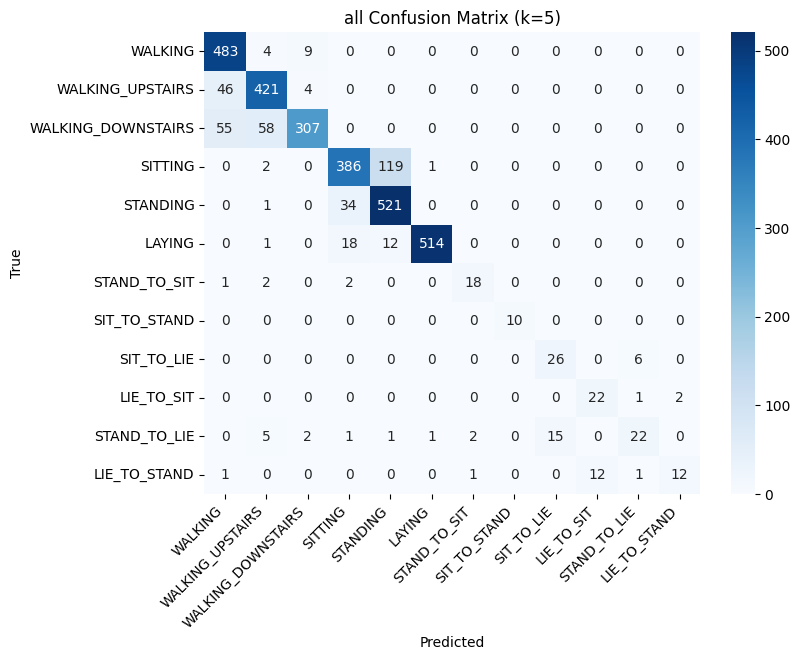

: 

In [ ]:
print("\nConfusion matrices for best CV k per subset:")
for name in subsets:
    vals = cv_f1_results[name]
    best_idx = int(np.argmax(vals))
    best_k = ks[best_idx]
    pipe.set_params(knn__n_neighbors=best_k, knn__weights='distance')
    Xtr, Xte = subsets[name]
    pipe.fit(Xtr, y_train)
    y_pred = pipe.predict(Xte)

    print(f'\n=== {name} (best k={best_k}) ===')
    print('Train F1 macro:', round(f1_score(y_train, pipe.predict(Xtr), average='macro'),4))
    print('Test  F1 macro:', round(f1_score(y_test, y_pred, average='macro'),4))
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{name} Confusion Matrix (k={best_k})'); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(rotation=45, ha='right'); plt.show()